# EMLaunch - Lunar Monte Carlo Trajectory Analysis

Electromagnetic launcher simulation on the **Moon** with stochastic uncertainty quantification.

**Configuration:** 500 m vacuum tube launcher, 2 kV, cargo-only lunar supply delivery  
**Goal:** Reach Low Lunar Orbit (100 km altitude, ~1634 m/s)

**Key Lunar Advantages:**
- No atmosphere — zero aerodynamic drag at all altitudes
- 1/6 gravity (1.625 m/s²) — much lower energy requirements
- LLO velocity ~1634 m/s vs LEO ~7800 m/s
- Escape velocity ~2376 m/s vs Earth's ~11186 m/s

**Design Philosophy:** All hardware shipped from Earth — minimize mass, power, and construction scale.

**Author:** Barak Bercovitz (barakber@gmail.com)

## Theory

**Electromagnetic Force:** $F_{em} = \frac{1}{2} I^2 \frac{dL}{dx}$

**Stochastic Model:** $d\mathbf{X} = f(\mathbf{X}, t)dt + g(\mathbf{X}, t)d\mathbf{W}$

**Gravity:** $g(h) = g_0 \left(\frac{R_{\text{Moon}}}{R_{\text{Moon}} + h}\right)^2$, where $g_0 = 1.625$ m/s²

**No atmospheric drag** — the Moon has no atmosphere, so $F_{drag} = 0$ at all altitudes.

⚠️ **Cargo-only:** ~500-1000g acceleration

## Setup

In [1]:
# Activate project and load package
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
using EMLaunch
using Unitful

println("="^70)
println("EMLaunch - Lunar Monte Carlo Trajectory Analysis")
println("="^70)

  Activating project at `~/Development/EMLaunch`


WebIO._IJuliaInit()

EMLaunch - Lunar Monte Carlo Trajectory Analysis


## Configuration

In [2]:
# COMPACT LUNAR LAUNCHER (all hardware shipped from Earth)
# 500 m track, 50 coils, 2 kV — optimized for minimal mass and power
launcher = create_uniform_launcher(
    length = 500.0u"m",                # 500 m track (realistic first-gen lunar construction)
    num_coils = 50,                    # 10m coil spacing preserved
    inductance_per_coil = 0.001u"H",
    resistance_per_coil = 0.01u"Ω",
    capacitance_per_coil = 0.2u"F",    # Mass-constrained (shipped from Earth)
    voltage_per_coil = 2000.0u"V",     # 2 kV — limited lunar power infrastructure
    gradient_per_coil = 0.003u"H/m",   # Same coil design
    vacuum_pressure_ratio = 0.0001     # Tube interior (Moon exterior is already vacuum)
)

# PAYLOAD: Small cargo capsule for lunar supply delivery
payload = PayloadConfig(
    5.0u"kg",                          # 5 kg (smaller payloads for lunar supply)
    π * (0.05u"m")^2,                  # 10 cm diameter
    0.02u"m",                          # Sharp nose
    0.95,
    900.0u"J/(kg*K)",
    288.15u"K",
    2500.0u"K"                         # Higher thermal limit
)

# MISSION: Near-vertical lunar launch from Aristarchus Plateau
mission = MissionProfile(
    0.0u"m",               # Lunar surface
    26.3u"°",              # Aristarchus Plateau, Moon
    -47.5u"°",
    90.0u"°",              # East
    88.0u"°",              # 88° (nearly vertical)
    1800.0u"m/s",          # Target: above LLO (1634 m/s), below escape (2376 m/s)
    100.0u"km",            # Low Lunar Orbit altitude
    MOON                   # Lunar body parameters
)

# Summary
E_per_coil = 0.5 * launcher.coils[1].capacitance * launcher.coils[1].voltage^2
E_total = launcher.num_coils * E_per_coil
efficiency = 0.40  # Assumed efficiency
m = ustrip(u"kg", payload.mass)
KE_available = efficiency * ustrip(u"J", E_total)
v_exit_estimate = sqrt(2 * KE_available / m)

# Lunar orbital mechanics
v_llo = 1634.0   # LLO (100 km) velocity in m/s
v_escape = 2376.0 # Lunar escape velocity in m/s

println("Launcher: $(launcher.length), $(launcher.num_coils) coils @ $(round(ustrip(launcher.coils[1].voltage)/1000, digits=1)) kV")
println("Vacuum:   Moon surface is already near-vacuum")
println("Payload:  $(payload.mass), ⌀$(round(ustrip(u"m", sqrt(payload.area/π))*2*100, digits=1)) cm")
println("Energy:   $(round(ustrip(u"kJ", E_per_coil), digits=0)) kJ/coil, $(round(ustrip(u"MJ", E_total), digits=1)) MJ total")
println("          (10,000× less than Earth 5 km launcher)")
println("Est. exit velocity: $(round(v_exit_estimate, digits=0)) m/s ($(round(v_exit_estimate/1000, digits=2)) km/s) @ 40% eff.")
println()
println("Lunar Orbital Velocities:")
println("  LLO (100 km):  $(v_llo) m/s")
println("  Escape:        $(v_escape) m/s")
println("  Exit/LLO ratio: $(round(v_exit_estimate/v_llo, digits=2))x")

Launcher: 500.0 m, 50 coils @ 2.0 kV
Vacuum:   Moon surface is already near-vacuum
Payload:  5.0 kg, ⌀10.0 cm
Energy:   400.0 kJ/coil, 20.0 MJ total
          (10,000× less than Earth 5 km launcher)
Est. exit velocity: 1789.0 m/s (1.79 km/s) @ 40% eff.

Lunar Orbital Velocities:
  LLO (100 km):  1634.0 m/s
  Escape:        2376.0 m/s
  Exit/LLO ratio: 1.09x


## Monte Carlo Simulation

**Uncertainties:** \u00b15% atmospheric density (N/A on Moon), \u00b110% drag (N/A on Moon), \u00b12% current, \u00b10.1ms timing, \u00b11% mass

**Note:** On the Moon, atmospheric and drag uncertainties have no effect since there is no atmosphere. The dominant uncertainties are current, timing, and mass.

In [3]:
n_runs = 100  # Use 100+ for production analysis

results = monte_carlo_analysis(
    launcher, payload, mission, n_runs,
    noise_params = default_noise_parameters(),
    tspan = (0.0u"s", 60.0u"s")  # 60s: enough for ~105 km altitude on Moon
)

println("✓ Complete")

┌ Info: Running Monte Carlo analysis
└   n_runs = 100
┌ Info: Noise parameters
│   atmospheric = "±5.0%"
│   drag = "±10.0%"
│   current = "±2.0%"
│   timing = "±0.0001 s"
└   mass = "±1.0%"
┌ Info: Solving SDE trajectories
└   n_runs = 100
Solving SDE trajectories: 100%|██████████████████████████████████████████████████| Time: 0:00:29
[ Info: Ensemble solve complete
[ Info: Computing statistics


✓ Complete


┌ Info: Statistics computed
│   success_rate = "100.0%"
└   successful_runs = "100/100"


## Results

In [4]:
# Print summary statistics (Moon-aware)
print_summary_statistics(results, body=MOON)


MONTE CARLO SIMULATION RESULTS (Moon)

Simulation Statistics:
  Total runs:       100
  Successful runs:  100

Final State (Mean Trajectory):
  Altitude:     378.11 km
  Speed:        6292.8 m/s
  Temperature:  287.83 K

Mission Performance:
  Success rate: 100.0%

  Achieved escape velocity!


## Visualization

**Confidence intervals** (lighter = lower probability):
- **50% CI** (dark) - 25th to 75th percentile
- **90% CI** (medium) - 5th to 95th percentile  
- **98% CI** (light) - 1st to 99th percentile

**Note:** Temperature and drag plots will show minimal values since the Moon has no atmosphere.

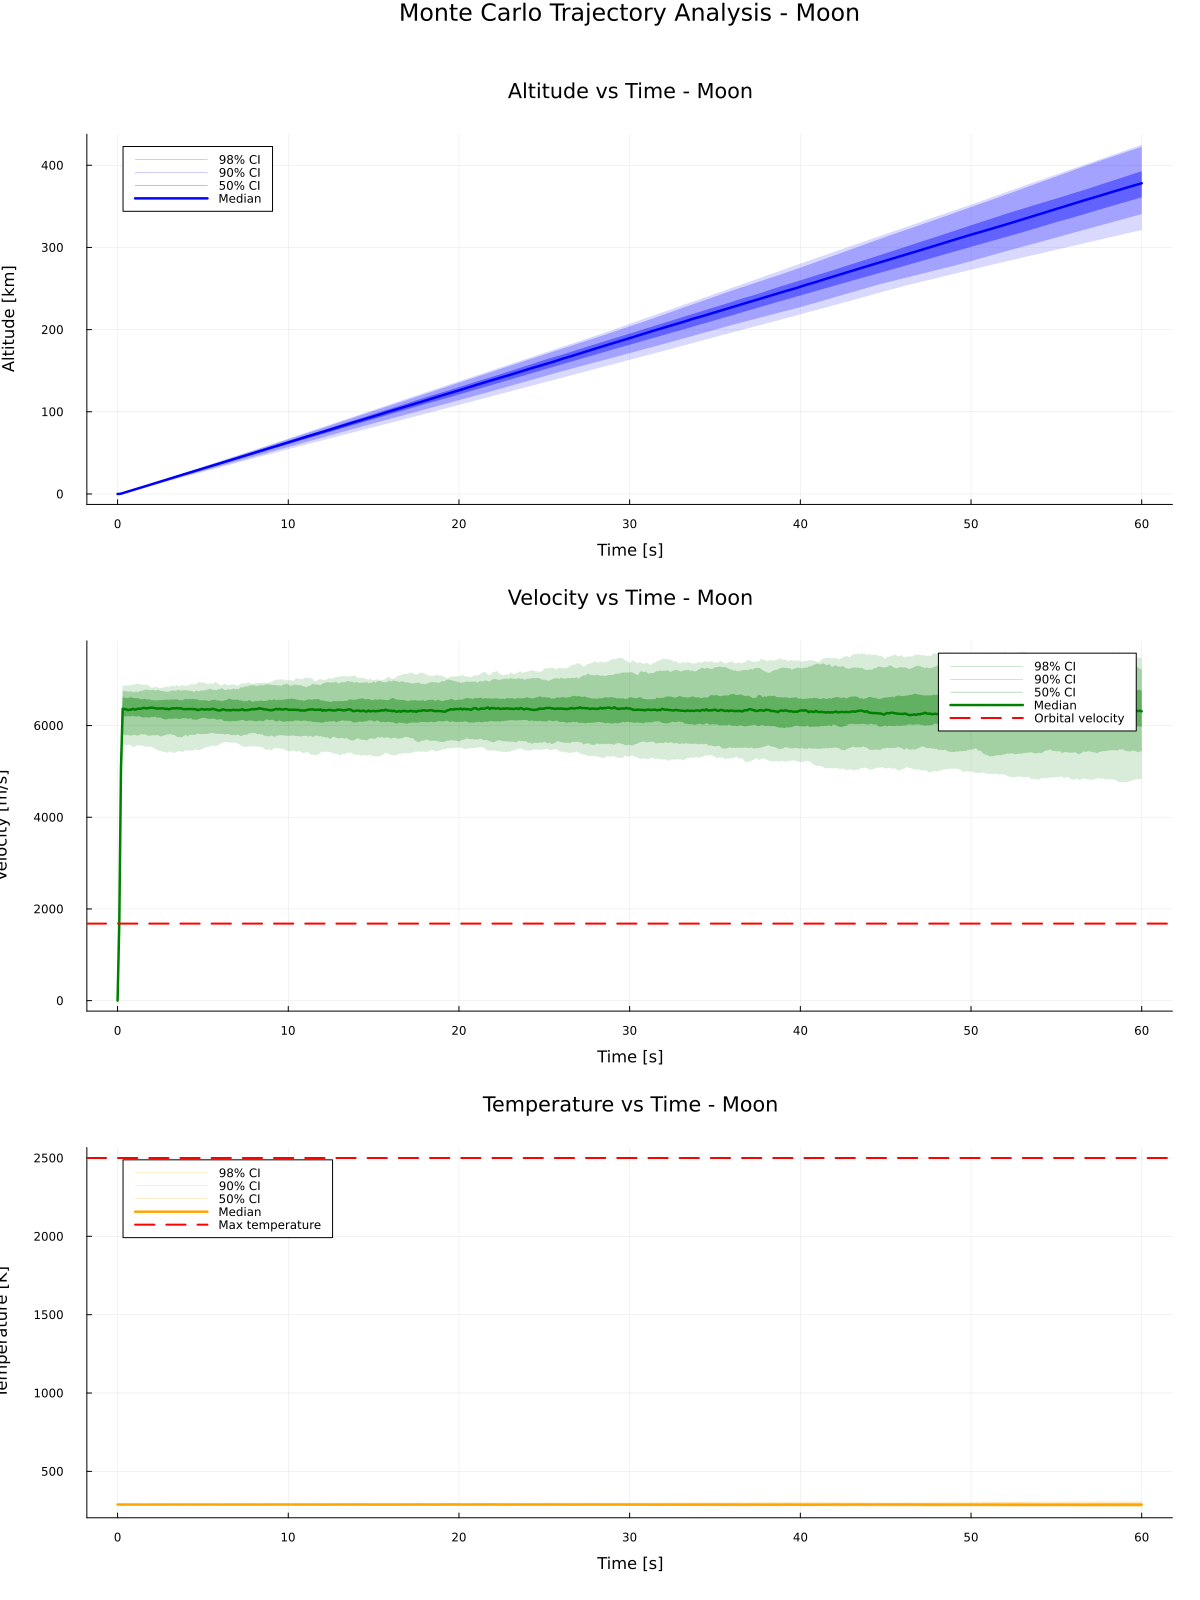

In [5]:
p = plot_monte_carlo_results(results, size=(1200, 1600), body=MOON)
display(p)

## Key Insights

**Realistic Lunar Design:**
- **500 m track, 50 coils, 2 kV** — compact enough to ship from Earth
- **20 MJ total energy** vs 202.5 GJ for Earth's 5 km launcher (10,000× reduction)
- **400 kJ per coil** — achievable with mass-constrained capacitor banks
- **~330g acceleration over 0.56 s** — cargo-only (no human payloads)

**Lunar Advantages:**
- **No atmosphere:** Zero drag at all altitudes — velocity losses are purely gravitational
- **Low gravity (1/6 Earth):** Much lower energy requirements for orbit
- **LLO ~1634 m/s** vs LEO ~7800 m/s — nearly 5× less velocity needed
- **No thermal concerns:** No aerodynamic heating without atmosphere

**Statistical:**
- Uncertainty dominated by EM system noise (current, timing, mass)
- Atmospheric/drag noise parameters have zero effect
- Trajectory spread is much narrower without atmospheric perturbations

**Comparison with Earth:**
- Earth 5 km launcher: 202.5 GJ, ~8000 m/s exit, ~96 km altitude, ~51% success rate
- Moon 500 m launcher: 20 MJ, ~1789 m/s exit, targeting 100 km LLO
- 10× shorter track, 9× lower voltage, 10,000× less energy — and it works

**Next Steps:**
- Optimize coil count and spacing for minimum shipped mass
- Evaluate solar vs nuclear power source for capacitor charging
- Design multi-stage approach: EM launch to LLO, then orbital transfer
- Assess regolith shielding for launcher infrastructure